<a href="https://colab.research.google.com/github/RPGraciotti/BootCampAlura/blob/main/Modulo_6/Aula_4_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparando conteúdo anterior

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
!pip install scikit-learn==0.23.2 imbalanced-learn==0.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.1/167.1 KB 19.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.2 which is incompatible.


In [3]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [4]:
df_cadastrados = pd.read_csv("https://github.com/RPGraciotti/BootCampAlura/raw/main/Data/clientes_cadastrados.txt")
ids_repetidos = df_cadastrados[df_cadastrados.loc[:,"ID_Cliente"].duplicated(keep = False)].loc[:,"ID_Cliente"]
df_cadastrados_no_rep = df_cadastrados.drop(ids_repetidos.index)

df_cadastrados_no_rep.loc[:,"Anos_empregado"] = df_cadastrados_no_rep.loc[:,"Anos_empregado"].replace(-1000.7, -1)

rend = df_cadastrados_no_rep.loc[:,"Rendimento_Anual"]
rend_mean = rend.mean()
rend_std = rend.std()

lim_sup = rend_mean + (2 * rend_std)
lim_inf = rend_mean - (2 * rend_std) # esse aqui você pode perceber que ficou negativo, e vimos que não há valores negativos nesse dado, então não haverá perdas

index_outliers = [] # lista vazia para for, mesma lógica no R

for index, valor in rend.items():
  if valor > lim_sup or valor < lim_inf:
    index_outliers.append(index)

df_cadastrados_no_out = df_cadastrados_no_rep.drop(index_outliers)

quant_cols = ['Idade', 'Qtd_Filhos', 'Rendimento_Anual', 'Anos_empregado', 'Tamanho_Familia']
cat_cols = ["Genero", "Tem_Carro", "Tem_Casa_Propria", "Categoria_de_renda", "Grau_Escolaridade", "Estado_Civil",
            "Moradia", "Tem_Celular", "Tem_telefone_trabalho", "Tem_telefone_fixo", "Tem_email", "Ocupacao"]


df_cad_trat1 = df_cadastrados_no_out.drop(["Genero", "Tem_Celular"], axis = 1)

cat_cols.remove("Genero")
cat_cols.remove("Tem_Celular")

df_aprovados = pd.read_csv("https://raw.githubusercontent.com/RPGraciotti/BootCampAlura/main/Data/clientes_aprovados.txt")
df_aprovados_agrupados_ID = df_aprovados.groupby('ID_Cliente')
srs_abertura = df_aprovados_agrupados_ID.apply(lambda x: min(x['Mes_referencia'])) # srs == series
srs_abertura.name = 'Abertura'

df_aprovados = df_aprovados.merge(srs_abertura, on = "ID_Cliente")

srs_final = df_aprovados_agrupados_ID.apply(lambda x: max(x['Mes_referencia']))
srs_final.name = 'Final'

df_aprovados = df_aprovados.merge(srs_final, on = "ID_Cliente")
df_aprovados.loc[:,'Janela'] = df_aprovados.loc[:,'Final'] - df_aprovados.loc[:,'Abertura']

df_aprovados.loc[:,'MOB'] = df_aprovados.loc[:,'Mes_referencia'] - df_aprovados.loc[:,'Abertura']

dict_faixa_atraso_ind ={'nenhum empréstimo': 0, 'pagamento realizado': 1,
                        '1-29 dias': 2, '30-59 dias': 3, '60-89 dias': 4,
                        '90-119 dias': 5, '120-149 dias': 6, '>150 dias': 7}

df_aprovados.loc[:,'Ind_Faixa_atraso'] = df_aprovados.loc[:,"Faixa_atraso"].map(dict_faixa_atraso_ind)
df_aprovados.loc[:,'Mau'] = df_aprovados.apply(lambda x: 1 if x['Ind_Faixa_atraso'] > 3 else 0, axis = 1) # atentar para o fato do método .loc não funcionar dentro do lambda?

df_aprovados_ID = df_aprovados.loc[:,('ID_Cliente', 'Abertura', 'Final', 'Janela')].groupby('ID_Cliente').apply(lambda x: x.iloc[0]).reset_index(drop = True)

df_denominador = df_aprovados_ID.groupby('Abertura').apply(lambda x: x['ID_Cliente'].count()).reset_index()
df_denominador.columns = ['Abertura', 'Qtd_Clientes']

df_vintage = df_aprovados.groupby(['Abertura', 'MOB']).apply(lambda x: x['ID_Cliente'].count()).reset_index()
df_vintage.columns = ['Abertura', 'MOB', 'Qtd_Clientes']
df_vintage = pd.merge(df_vintage.loc[:,('Abertura', 'MOB')], df_denominador, on = ['Abertura'], how = 'left')

df_vintage['Qtd_Mau'] = np.nan

for j in range(-60,1):
    ls = []
    for i in range(0,61):
        due = list(df_aprovados.query('Mau == 1 and MOB == @i and Abertura == @j')['ID_Cliente'])
        ls.extend(due)
        df_vintage.loc[(df_vintage['MOB'] == i) & (df_vintage['Abertura'] == j), 'Qtd_Mau'] = len(set(ls))
        
df_vintage['Taxa_de_Mau']  = df_vintage['Qtd_Mau'] / df_vintage['Qtd_Clientes']

df_vintage_pivot = df_vintage.pivot(index = 'Abertura',
                                    columns = 'MOB',
                                    values = 'Taxa_de_Mau')

dict_intervalo_atraso = {'maior_30_dias': 3, 'maior_60_dias': 4, 'maior_90_dias': 5,
                        'maior_120_dias': 6, 'maior_150_dias': 7}

for chave, valor in dict_intervalo_atraso.items():
  df_aprovados[f'Mau_{chave}'] = df_aprovados.apply(lambda x: 1 if x['Ind_Faixa_atraso'] >= valor else 0, axis=1) # mais de 60

dict_taxa_mau = {}
id_sum = len(set(df_aprovados['ID_Cliente']))

for chave in dict_intervalo_atraso.keys():
  df_min_mau = df_aprovados.query(f'Mau_{chave} == 1').groupby('ID_Cliente')['MOB'].min().reset_index()
  df_mob_taxa_mau = pd.DataFrame({'MOB':range(0,61), 'Taxa_Mau': np.nan})
  lst = []
  for i in range(0,61):
      due = df_min_mau.query('MOB == @i')['ID_Cliente'].to_list()
      lst.extend(due) #cumsum
      df_mob_taxa_mau.loc[df_mob_taxa_mau['MOB'] == i, 'Taxa_Mau'] = len(set(lst)) / id_sum
  dict_taxa_mau[chave] = df_mob_taxa_mau['Taxa_Mau']

df_taxa_mau = pd.DataFrame(dict_taxa_mau)

df_aprovados_trat1 = df_aprovados.query('Janela >= 12').copy() # trat1 = tratamento 1

def verifica(registros):
  lista_status = registros['Faixa_atraso'].to_list()
  if '60-89 dias' in lista_status or '90-119 dias' in lista_status or '120-149 dias' in lista_status or '>150 dias' in lista_status:
    return 1
  else:
    return 0
  
df_registros_creditos_id = pd.DataFrame(df_aprovados_trat1.groupby('ID_Cliente').apply(verifica)).reset_index()
df_registros_creditos_id.columns = ['ID_Cliente', 'Mau']

df_registro_clientes_targets = df_cad_trat1.merge(df_registros_creditos_id, on='ID_Cliente')

##Sessão 1 - Primeiros modelos

In [5]:
df_registro_clientes_targets['Mau'].value_counts(normalize=True)*100

0    97.726673
1     2.273327
Name: Mau, dtype: float64

In [6]:
cat_col_bin  = ['Tem_Carro',
                'Tem_Casa_Propria',
                'Tem_telefone_trabalho',
                'Tem_telefone_fixo',
                'Tem_email']
cat_col_bin

['Tem_Carro',
 'Tem_Casa_Propria',
 'Tem_telefone_trabalho',
 'Tem_telefone_fixo',
 'Tem_email']

In [7]:
cat_col_n_bin = ['Categoria_de_renda',
                 'Grau_Escolaridade',
                 'Estado_Civil',
                 'Moradia',
                 'Ocupacao']
cat_col_n_bin

['Categoria_de_renda',
 'Grau_Escolaridade',
 'Estado_Civil',
 'Moradia',
 'Ocupacao']

In [8]:
df_registro_clientes_targets = df_registro_clientes_targets[['ID_Cliente'] + quant_cols + cat_col_bin + cat_col_n_bin + ['Mau']]
df_registro_clientes_targets.head()

,ID_Cliente,Idade,Qtd_Filhos,Rendimento_Anual,Anos_empregado,Tamanho_Familia,Tem_Carro,Tem_Casa_Propria,Tem_telefone_trabalho,Tem_telefone_fixo,Tem_email,Categoria_de_renda,Grau_Escolaridade,Estado_Civil,Moradia,Ocupacao,Mau
0,5008806,59.0,0,112500.0,3.1,2.0,1,1,0,0,0,Empregado,Ensino medio,Casado,Casa propria,Seguranca,0
1,5008810,52.0,0,270000.0,8.4,1.0,0,1,0,1,1,Associado comercial,Ensino medio,Solteiro,Casa propria,Venda,0
2,5008811,52.0,0,270000.0,8.4,1.0,0,1,0,1,1,Associado comercial,Ensino medio,Solteiro,Casa propria,Venda,0
3,5008812,62.0,0,283500.0,-1.0,1.0,0,1,0,0,0,Pensionista,Ensino superior,Separado,Casa propria,Outros,0
4,5008813,62.0,0,283500.0,-1.0,1.0,0,1,0,0,0,Pensionista,Ensino superior,Separado,Casa propria,Outros,0


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, plot_confusion_matrix
from scipy import stats

In [10]:
# função disponível no notebook https://github.com/alura-cursos/Avaliacao_Credito/blob/main/notebooks/aula4.ipynb
SEED = 1561651
def roda_modelo(modelo, dados):

    # separando dados em x e y, e tambem removendo a coluna de ID_cliente
    x = dados.drop(['ID_Cliente', 'Mau'], axis=1)
    y = dados.drop('ID_Cliente', axis=1)['Mau']
    
    # Separando dados em treino e teste
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=SEED)

    # Treinando modelo com os dados de treino
    modelo.fit(x_train, y_train)

    # Calculando a probabilidade e calculando o AUC
    prob_predic = modelo.predict_proba(x_test)
    auc = roc_auc_score(y_test, prob_predic[:,1])
    print(f"AUC {auc}")
    
    # Separando a probabilidade de ser bom e mau, e calculando o KS
    data_bom = np.sort(modelo.predict_proba(x_test)[:, 1])
    data_mau = np.sort(modelo.predict_proba(x_test)[:, 0])
    kstest = stats.ks_2samp(data_bom, data_mau)
    print(f"KS {kstest}")

    # Criando matriz de confusão
    matriz_confusao = plot_confusion_matrix(modelo, x_test, y_test, values_format='.0f', display_labels=['Bons', 'Maus'])
    plt.grid(False)    
    plt.show(matriz_confusao)

    # Fazendo a predicao dos dados de teste e calculando o classification report
    predicao = modelo.predict(x_test)
    print("\nClassification Report")
    print(classification_report(y_test, predicao, zero_division=0))

![grafico](https://raw.githubusercontent.com/RPGraciotti/BootCampAlura/main/Modulo_6/fig_1.png)

Modificação da função **roda_modelo** para utilizar a métrica **KS**.

1. Depois que já termos o modelo treinando, vamos calcular probabilidade do modelo classificar os dados como Mau para os dados de teste e salvar na váriavel **data_mau**.

2. Para isso utilizamos o método **predict_proba** nos dados de teste **x_test**, e depois aplicamos os slices para pegarmos apenas a possibilidade de uma das labels **[:, 1]**, por fim ordenamos a probabilidade da maior para a menor.

3. Depois repetimos o mesmo processo para a variavel **data_bom**, mudando apenas o nosso slice **[:, 0]** para pegarmos agora a possibilidades da outra label.

4. Finalmente podemos utilizar o **ks_2samp** da biblioteca **stats** para calcular a métrica KS, vamos enviar as variaveis **data_bom** e **data_mau** para a função **ks_2samp**.

"o KS mede a maior distância entre a probabilidade de um registro ser bom e a probabilidade de ser mau"

"predict_proba mede a probabilidade de um registro ser 0 e probabilidade de ser 1"

In [11]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

Criar a classe **Transformador**.

1. Primeiro vamos herdar as classes **BaseEstimator** e a **TransdormerMixin**.

2. Depois vamos criar o método construtor **\_\_init\_\_** e vamos criar uma assinatura com os parametros **quant_cols** e **cat_cols**. Vamos atribuir essas parametros a variaveis de mesmo nome. 

3. Outro ponto foi que vamos instanciar o **OneHotEnconder** e o **MinMaxScaler**, criando assim os métodos **enc** e o **scaler**.

4. O proximo método que devemos criar é o **fit** e ele já tem sua assinatura padrão que é receber os variaveis **X** e **y**. Dentro do **fit** nosso objetivo é treinar nossos trasformadores **enc** e **scaler** com seus respectivos dados categoricos para o enc e continuos para o scaler. Vamos fazer isso novamente utilizando o slice na vairavel X, utilizando como parametro o atributos **self.cat_cols** para o **self.enc.fit** e  **self.quant_cols** para o **self.scaler.fit**.

5. O ultimo método é o **transform** e o que vamos fazer nele é aplicar as transformações, novamente tomando o cuidado de utilizar o **slice** para pegarmos apenas os dados coerentes para cada transformador **self.enc.transform(X[self.cat_cols])**, e depois criar um DataFrame com os novos dados transformados.

6. Repetimos o mesmo processo para as colunas continuas, **self.scaler.transform(X[self.quant_cols]**, e tambem criando o novo DataFrame **X_continuas**.

7. Agora que temos os dataframes com nossos dados transformados podemos unificar eles com o **pd.concat** e retorna o novo DataFrame com o **return X**

In [12]:
# PEP8 padrão CamelCase
class Transformador(BaseEstimator, TransformerMixin):
    def __init__(self, quant_cols, cat_cols):
        self.quant_cols = quant_cols
        self.cat_cols = cat_cols
        self.enc = OneHotEncoder()
        self.scaler = MinMaxScaler()

    def fit(self, X, y = None ):
        self.enc.fit(X[self.cat_cols])
        self.scaler.fit(X[self.quant_cols])
        return self 

    def transform(self, X, y = None):
      
      X_categoricas = pd.DataFrame(data=self.enc.transform(X[self.cat_cols]).toarray(),
                                  columns= self.enc.get_feature_names(self.cat_cols))
      
      X_continuas = pd.DataFrame(data=self.scaler.transform(X[self.quant_cols]),
                                  columns= self.quant_cols)
      
      X = pd.concat([X_continuas, X_categoricas], axis=1)

      return X

In [13]:
from sklearn.pipeline import Pipeline

### Dummy Classifier

AUC 0.5
KS KstestResult(statistic=1.0, pvalue=0.0)


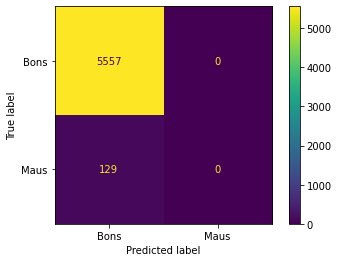


Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5557
           1       0.00      0.00      0.00       129

    accuracy                           0.98      5686
   macro avg       0.49      0.50      0.49      5686
weighted avg       0.96      0.98      0.97      5686



In [14]:
pipeline = Pipeline([('Transformador', Transformador(quant_cols, cat_cols)),
                     ('Modelo', DummyClassifier(strategy = 'prior'))])
roda_modelo(pipeline, df_registro_clientes_targets)

DummyClassifier está chutando apenas uma classe, no caso, bons. Acurácia 0.98 engana! Porém, no contexto de ir construindo o entedimento do modelo, começar com o dummy "não funcionando", vai nos informar bem mais sobre como outros modelos irão funcionar.

AUC 0.5847293657137516
KS KstestResult(statistic=1.0, pvalue=0.0)


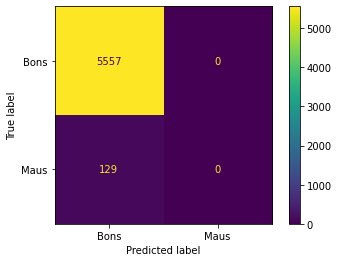


Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5557
           1       0.00      0.00      0.00       129

    accuracy                           0.98      5686
   macro avg       0.49      0.50      0.49      5686
weighted avg       0.96      0.98      0.97      5686



In [15]:
pipeline = Pipeline([('Transformador', Transformador(quant_cols, cat_cols)),
                     ('Modelo', LogisticRegression(random_state = SEED, max_iter = 1000))])
roda_modelo(pipeline, df_registro_clientes_targets)

Continua o mesmo resultado péssimo!

Será que o problema está no desbalanceamento dos dados? Vamos aplicar um método para contornar essa situação.

## Sessão 2 - Tratando o desbalanceamento dos dados

Oversampling é um método que propõe rebalancear dados de treino apenas, através de dados sintéticos. Claro, afinal você não pode usar dados simulados no teste que são os seus dados de fato, seria manipulação dos resultados.

In [16]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

## https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

AUC 0.581681320996076
KS KstestResult(statistic=0.12926486106225818, pvalue=8.449404974877798e-42)


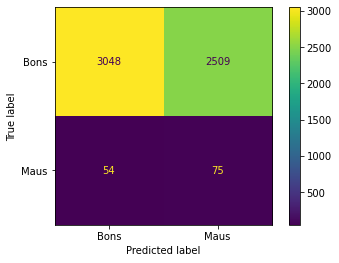


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.55      0.70      5557
           1       0.03      0.58      0.06       129

    accuracy                           0.55      5686
   macro avg       0.51      0.56      0.38      5686
weighted avg       0.96      0.55      0.69      5686



In [17]:
pipeline = Pipeline([('Transformador', Transformador(quant_cols, cat_cols)),
                     ('sampling', SMOTE(random_state=SEED)),
                     ('Modelo', LogisticRegression(random_state=SEED, max_iter=1000))])   
roda_modelo(pipeline, df_registro_clientes_targets)

In [18]:
from sklearn.ensemble import RandomForestClassifier

AUC 0.8382939040500634
KS KstestResult(statistic=0.9794231445655998, pvalue=0.0)


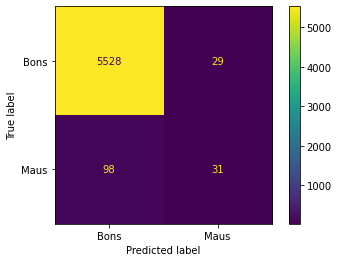


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5557
           1       0.52      0.24      0.33       129

    accuracy                           0.98      5686
   macro avg       0.75      0.62      0.66      5686
weighted avg       0.97      0.98      0.97      5686



In [19]:
pipeline = Pipeline([('Transformador', Transformador(quant_cols, cat_cols)),
                     ('Modelo', RandomForestClassifier(random_state = SEED))])   
roda_modelo(pipeline, df_registro_clientes_targets)

AUC 0.8340043216670643
KS KstestResult(statistic=0.9653534998241294, pvalue=0.0)


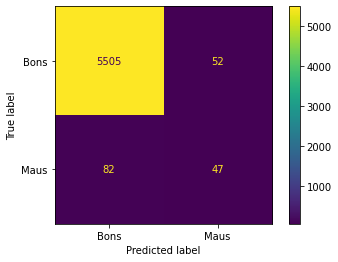


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5557
           1       0.47      0.36      0.41       129

    accuracy                           0.98      5686
   macro avg       0.73      0.68      0.70      5686
weighted avg       0.97      0.98      0.97      5686



In [20]:
pipeline = Pipeline([('Transformador', Transformador(quant_cols, cat_cols)),
                     ('sampling', SMOTE(random_state = SEED)),
                     ('Modelo', RandomForestClassifier(random_state = SEED))])   
roda_modelo(pipeline, df_registro_clientes_targets)

### Desafio 01 - Explorar undersampling

### Desafio 02 - Buscar outros métodos como XGboost

### Desafio 03 - Utilizar otimização de hiperparametros e seleção de features